In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [7]:
# ----------------------------- ตั้งค่า -----------------------------
DATA_DIR = r"C:\Users\HP\Desktop\LSTM\data\eeg_custom_10s"
BATCH_SIZE = 32
NUM_EPOCHS = 60  # ตั้งตามที่ต้องการ (ไม่มี early stop แล้ว)
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHUNK_SIZE = 2560  # 256 Hz * 10 s (ปรับเป็น 2660 ถ้าข้อมูลจริง 266 Hz)
NUM_CLASSES = 5

print(f"Device: {DEVICE}")

Device: cpu


In [3]:
# ----------------------------- U-Sleep Simplified (ขนาดเล็กลง) -----------------------------
class USleepSimplified(nn.Module):
    def __init__(self, in_channels=1, n_classes=5, base_filters=16):  # ลดจาก 32 → 16
        super(USleepSimplified, self).__init__()
        
        # Encoder (ลดเหลือ 2 ระดับ)
        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, base_filters, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(base_filters),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(base_filters, base_filters*2, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(base_filters*2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        # Bottleneck (ลดขนาด)
        self.bottleneck = nn.Sequential(
            nn.Conv1d(base_filters*2, base_filters*4, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(base_filters*4),
            nn.ReLU()
        )
        
        # Decoder (2 ระดับ)
        self.up2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv1d(base_filters*4, base_filters*2, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(base_filters*2),
            nn.ReLU()
        )
        
        self.up1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv1d(base_filters*2, base_filters, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(base_filters),
            nn.ReLU()
        )
        
        # Final
        self.final = nn.Conv1d(base_filters, n_classes, kernel_size=1)

    def forward(self, x):
        # x: (batch, 1, time)
        
        # Encoder
        e1 = self.enc1(x)   # time // 2
        e2 = self.enc2(e1)  # time // 4
        
        # Bottleneck
        b = self.bottleneck(e2)
        
        # Decoder + skip with interpolate
        d2 = self.up2(b)
        e2_interp = F.interpolate(e2, size=d2.size(2), mode='linear', align_corners=False)
        d2 = torch.cat([d2, e2_interp], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        e1_interp = F.interpolate(e1, size=d1.size(2), mode='linear', align_corners=False)
        d1 = torch.cat([d1, e1_interp], dim=1)
        d1 = self.dec1(d1)
        
        out = self.final(d1)
        out = out.mean(dim=2)  # Global average pooling → (batch, n_classes)
        return out

In [4]:
class SleepDataset(Dataset):
    def __init__(self, file_list):
        self.X = []
        self.y = []
        for file in file_list:
            data = np.load(file)
            self.X.append(data['X'])
            self.y.append(data['y'])
        self.X = np.concatenate(self.X, axis=0)
        self.y = np.concatenate(self.y, axis=0)
        print(f"Loaded {len(self.X)} epochs")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float().squeeze(-1)  # (2560,)
        x = x.unsqueeze(0)                                    # (1, 2560)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [5]:
# ----------------------------- โหลดและแบ่งข้อมูล -----------------------------
all_npz = glob.glob(os.path.join(DATA_DIR, "*.npz"))
if not all_npz:
    raise FileNotFoundError("No .npz files found")

train_files, temp_files = train_test_split(all_npz, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

train_dataset = SleepDataset(train_files)
val_dataset = SleepDataset(val_files)
test_dataset = SleepDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loaded 13581 epochs
Loaded 2562 epochs
Loaded 5670 epochs


In [8]:
# ----------------------------- โมเดล + Loss + Optimizer -----------------------------
model = USleepSimplified(n_classes=NUM_CLASSES).to(DEVICE)

# Weighted loss
unique, counts = np.unique(train_dataset.y, return_counts=True)
class_weights = 1.0 / counts
class_weights = torch.tensor(class_weights / class_weights.sum() * NUM_CLASSES, dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ----------------------------- Train (ไม่มี early stop) -----------------------------
print("\nเริ่ม train เต็มจำนวน epoch (ไม่มี early stop)...")
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation (เพื่อดูผล แต่ไม่หยุด)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            val_loss += criterion(outputs, y).item()
    
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print("\nTraining เสร็จสิ้น!")


เริ่ม train เต็มจำนวน epoch (ไม่มี early stop)...
Epoch 1/60 - Train Loss: 1.4503 | Val Loss: 1.6143
Epoch 2/60 - Train Loss: 1.3109 | Val Loss: 1.4814
Epoch 3/60 - Train Loss: 1.2353 | Val Loss: 1.6870
Epoch 4/60 - Train Loss: 1.1716 | Val Loss: 1.4090
Epoch 5/60 - Train Loss: 1.1253 | Val Loss: 1.3588
Epoch 6/60 - Train Loss: 1.0772 | Val Loss: 1.5860
Epoch 7/60 - Train Loss: 1.0483 | Val Loss: 1.5502
Epoch 8/60 - Train Loss: 1.0156 | Val Loss: 1.2110
Epoch 9/60 - Train Loss: 0.9903 | Val Loss: 1.3554
Epoch 10/60 - Train Loss: 0.9718 | Val Loss: 1.2031
Epoch 11/60 - Train Loss: 0.9490 | Val Loss: 1.2003
Epoch 12/60 - Train Loss: 0.9302 | Val Loss: 1.6150
Epoch 13/60 - Train Loss: 0.9135 | Val Loss: 1.2598
Epoch 14/60 - Train Loss: 0.9027 | Val Loss: 1.1372
Epoch 15/60 - Train Loss: 0.8854 | Val Loss: 1.1745
Epoch 16/60 - Train Loss: 0.8716 | Val Loss: 1.2485
Epoch 17/60 - Train Loss: 0.8637 | Val Loss: 1.0982
Epoch 18/60 - Train Loss: 0.8559 | Val Loss: 1.1961
Epoch 19/60 - Train Lo


Accuracy: 52.79%
Kappa: 0.3858
              precision    recall  f1-score   support

          N1       0.27      0.35      0.31       462
          N2       0.64      0.32      0.43      2349
          N3       0.45      0.97      0.61      1245
         REM       0.79      0.44      0.56      1167
        Wake       0.66      0.78      0.72       447

    accuracy                           0.53      5670
   macro avg       0.56      0.57      0.53      5670
weighted avg       0.60      0.53      0.51      5670



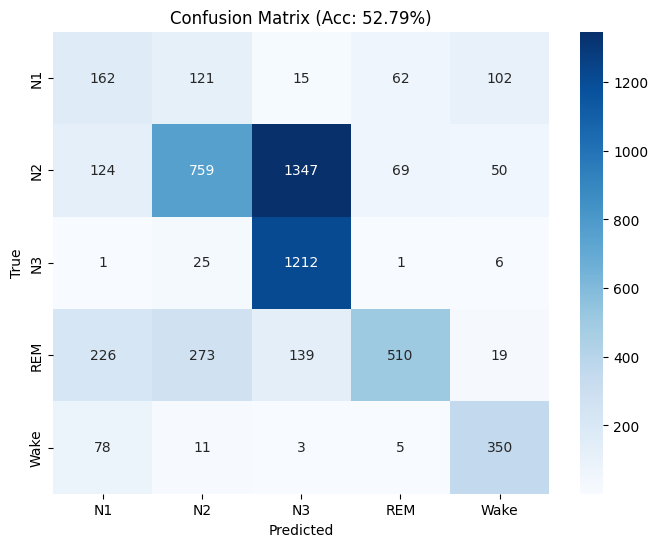

In [9]:
# ----------------------------- Evaluate -----------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print(f"\nAccuracy: {acc*100:.2f}%")
print(f"Kappa: {kappa:.4f}")
print(classification_report(y_true, y_pred, target_names=['N1', 'N2', 'N3', 'REM', 'Wake']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['N1', 'N2', 'N3', 'REM', 'Wake'],
            yticklabels=['N1', 'N2', 'N3', 'REM', 'Wake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Acc: {acc*100:.2f}%)')
plt.show()